# SMILES string Autoencoder

This Block
- Tokenizes SMILES string input using a tokenizer from Deepchem (which inherits from Huggingface/Transformers)
- Pads tokenized strings to max_length of the longest string
- vocab list has been pre-trimmed to what is contained in the 6731 dataset; for a new dataset use a full vocab list

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd 
import deepchem as dc
import time
import mordred
import transformers
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, Draw
from sklearn.model_selection import train_test_split
from deepchem.feat.smiles_tokenizer import SmilesTokenizer

#df = pd.read_csv("392-azo.csv")
#df = pd.read_csv("212-azo.csv")
#df = pd.read_csv("604-azo.csv")
#df = pd.read_csv("621-azo.csv")
df = pd.read_csv("6731-azo.csv")

Xa = [""]*len(df)
w = [""]*len(df)
i=0
for name in df["SMILES"]:
    Xa[i]=name
    w[i]=1.0
    i += 1
Xa = list(Xa)
w=list(w)

#===========================================================================================
#featurize, padding to max_length

tokenizer=dc.feat.SmilesTokenizer(vocab_file="vocab_new.txt")
featname="SMILES Tokenizer"

fl = list(map(lambda x: tokenizer.encode(x),Xa))
biggest = 1
for i in range(len(fl)):
    temp = len(fl[i])
    if temp > biggest:
        biggest = temp

print(biggest)
max_length = biggest
fl2 = list(map(lambda x: tokenizer.add_padding_tokens(x,max_length),fl))
#print(fl2[:5])
vocab_size=74

f = np.array(fl2)
print("Number of features and datapoints: ",f.shape)

#===========================================================================================
print("featurization done with: ",featname)

# set npp for how many points in the dataset, len(df) for whole dataset
nnp=len(df)

#set y to X
y = f

#set dataset

dataset = dc.data.NumpyDataset(X=f[:nnp,:], y=y[:nnp,:], ids=Xa[:nnp], w=w[:nnp])


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\ProgramData\Anaconda3\envs\rdkitenv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


105
Number of features and datapoints:  (6731, 105)
featurization done with:  SMILES Tokenizer


## Autoencoder Model
- Encoder is one GRU layer with 128 NTLUs
- Decoder is one GRU layer with 128 NTLUs, followed by a dense/softmax output layer 

In [2]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=12),
    tf.keras.layers.GRU(128,return_sequences=True)])

decoder = tf.keras.Sequential([
    tf.keras.layers.GRU(128,return_sequences=True),
    tf.keras.layers.Dense(vocab_size,activation="softmax")])

encode_decode=tf.keras.Sequential([encoder,decoder])

optimizer = tf.keras.optimizers.Nadam()
encode_decode.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer, metrics=["accuracy"])
model_chkpt = tf.keras.callbacks.ModelCheckpoint("SMILES_ED",monitor="val_accuracy",save_best_only=True)

history = encode_decode.fit(dataset.X,dataset.y,epochs=10,verbose=2,validation_split=0.1,callbacks=[model_chkpt])


Epoch 1/10


INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 46s - loss: 1.1893 - accuracy: 0.7049 - val_loss: 1.1194 - val_accuracy: 0.7114 - 46s/epoch - 240ms/step
Epoch 2/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 32s - loss: 0.2191 - accuracy: 0.9454 - val_loss: 0.4443 - val_accuracy: 0.9412 - 32s/epoch - 166ms/step
Epoch 3/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 32s - loss: 0.0430 - accuracy: 0.9919 - val_loss: 0.3780 - val_accuracy: 0.9654 - 32s/epoch - 170ms/step
Epoch 4/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 33s - loss: 0.0173 - accuracy: 0.9979 - val_loss: 0.3606 - val_accuracy: 0.9694 - 33s/epoch - 174ms/step
Epoch 5/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 34s - loss: 0.0095 - accuracy: 0.9990 - val_loss: 0.3629 - val_accuracy: 0.9700 - 34s/epoch - 178ms/step
Epoch 6/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 29s - loss: 0.0061 - accuracy: 0.9993 - val_loss: 0.3567 - val_accuracy: 0.9706 - 29s/epoch - 152ms/step
Epoch 7/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 31s - loss: 0.0042 - accuracy: 0.9994 - val_loss: 0.3573 - val_accuracy: 0.9724 - 31s/epoch - 165ms/step
Epoch 8/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 36s - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.3608 - val_accuracy: 0.9736 - 36s/epoch - 189ms/step
Epoch 9/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 31s - loss: 0.0023 - accuracy: 0.9997 - val_loss: 0.3593 - val_accuracy: 0.9743 - 31s/epoch - 162ms/step
Epoch 10/10
INFO:tensorflow:Assets written to: SMILES_ED\assets


INFO:tensorflow:Assets written to: SMILES_ED\assets


190/190 - 35s - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.3577 - val_accuracy: 0.9750 - 35s/epoch - 183ms/step


## Saves a model

In [73]:
encode_decode.save("28Feb_newvocab_embed12",save_format="tf")
print("model saved.")

INFO:tensorflow:Assets written to: 28Feb_newvocab_embed12\assets


INFO:tensorflow:Assets written to: 28Feb_newvocab_embed12\assets


model saved.


## Test model
- Takes 2 strings that are not in the dataset and runs them through the model
- Then takes the most probable token for each position
- de-tokenizes this, converts it to a SMILES string, and then creates and displays a graph

1/1 [==============================] - 1s 828ms/step
Input Molecule:         Oc1cc(cc(c1O)[N+]([O-])=O)C#N

Reconstructed Molecule: Oc1cc(cc(c1O)[N+]([O-])=O)C#N



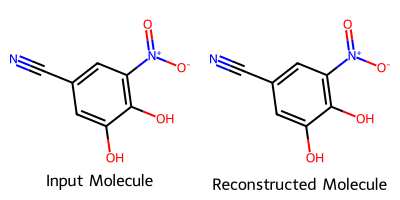

In [5]:
encode_decode = tf.keras.models.load_model("28Feb_newvocab_embed12")

test_string=[""]*2
test_array = np.empty((2,1))
test_xlist=[0]*2
firstmol_list = [0]

Xs=[""]*2
Xs[0] = "Oc1cc(cc(c1O)[N+]([O-])=O)C#N"
Xs[1] = "C(=O)C(C)=Cc1cc(O)c(O)c(c1)[N+]([O-])=O"

tl = list(map(lambda x: tokenizer.encode(x),Xs))
tl2 = list(map(lambda x: tokenizer.add_padding_tokens(x,max_length),tl))
testf = np.array(tl2)

test_xlist[0] = testf[0]
test_xlist[1] = testf[1]

test_array = np.array(test_xlist)

firstmol_list[0] = 1
results = encode_decode.predict(test_array)

for i in range(105):
    proba = results[0,i,:]
    first_pred = tf.argmax(proba)
    firstmol_list.append(int(first_pred))

firstmol_list.pop(0)
firstmol_array = np.array(firstmol_list)

new_molecule = tokenizer.decode(firstmol_list)

nm1 = tokenizer.convert_tokens_to_string(new_molecule).replace(" ","")
nm2 = nm1.replace("[CLS]","").replace("[SEP]","").replace("[PAD]","")

print(f"Input Molecule:         {Xs[0]}") 
print("")
print(f"Reconstructed Molecule: {nm2}")
print("")
mol1 = Chem.MolFromSmiles(Xs[0])
mol2 = Chem.MolFromSmiles(nm2)

mols = [mol1,mol2]
legends = ["Input Molecule","Reconstructed Molecule"]

Draw.MolsToGridImage(mols=mols, legends=legends,molsPerRow=2,maxMols=500)